## LLM Generalization with Function Vector Decomposition
Megan Luu, Essam Sleiman, Katherine Hunter

Code adapted from Todd et al. 2023:  https://github.com/ericwtodd/function_vectors

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf function_vectors
git clone https://github.com/kehunter/function_vectors.git

Cloning into 'function_vectors'...


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from numpy.linalg import norm
import random

random.seed(10)

!pip install git+https://github.com/davidbau/baukit
!pip install bitsandbytes
!pip install accelerate

In [ ]:
import os, re, json
import torch, numpy as np

import sys
sys.path.append('./function_vectors/')
torch.set_grad_enabled(False)

from src.utils.extract_utils import get_mean_head_activations, compute_universal_function_vector
from src.utils.intervention_utils import fv_intervention_natural_text, function_vector_intervention
from src.utils.model_utils import load_gpt_model_and_tokenizer
from src.utils.prompt_utils import load_dataset, word_pairs_to_prompt_data, create_prompt
from src.utils.eval_utils import decode_to_vocab, sentence_eval

## Load model & tokenizer

In [ ]:
model_name = 'gpt2-xl'
model, tokenizer, model_config = load_gpt_model_and_tokenizer(model_name)

Loading:  gpt2-xl


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Functions

In [ ]:
def get_FV(dataset_name):
    app_review_data = load_dataset(dataset_name, root_data_dir = "function_vectors/dataset_files",seed=0)
    mean_activations_app_review_data = get_mean_head_activations(app_review_data, model, model_config, tokenizer)
    FV_app_review_data, top_heads_app_review_data = compute_universal_function_vector(mean_activations_app_review_data, model, model_config, n_top_heads=10)

    return FV_app_review_data, app_review_data

def run_expt(dataset_name, fv, scalar = 1, edit_layer = 22, edit_layer2=None, function_vector2=None, normalized=False, rescale=1, print_statements=True):
  data = load_dataset(dataset_name, root_data_dir = "function_vectors/dataset_files",seed=0)
  FV = fv
  scalar = scalar

  EDIT_LAYER = edit_layer
  N_SAMPLES = 100

  Zero_shot_FV_result = []
  top1 = []
  top5 = []
  top10 = []

  # run on n amount of samples
  for i in range(0, N_SAMPLES):
      test_sample = data['test'][i]

      zeroshot_prompt_data = word_pairs_to_prompt_data({'input':[], 'output':[]}, query_target_pair=test_sample, prepend_bos_token=True, shuffle_labels=True)
      zeroshot_sentence = create_prompt(zeroshot_prompt_data)

      clean_logits, interv_logits, _, _ = function_vector_intervention(zeroshot_sentence, test_sample['output'],
                                                                 EDIT_LAYER, scalar*FV, model, model_config, tokenizer,
                                                                 edit_layer2=edit_layer2, function_vector2=function_vector2,
                                                                       normalized=normalized, rescale=rescale)

      # calc the avg performance across z-shot for k-shot with FV
      # ========================================================================
      top_k = decode_to_vocab(interv_logits, tokenizer, k=10)

      in_var = False
      for k in range(len(top_k)):
          prediction = str(top_k[k][0]).strip()
          ground_truth =  str(repr(test_sample['output'])[1:-1]).strip()
          if prediction == ground_truth:
              Zero_shot_FV_result.append(top_k[k][1])
              in_var = True
              k_found = k
      if in_var == False:
          Zero_shot_FV_result.append(0)
          k_found = -1
      if k_found == 0:
        top1.append(1)
        top5.append(1)
        top10.append(1)
      elif 1 <= k_found <=4:
        top1.append(0)
        top5.append(1)
        top10.append(1)
      elif 1<= k_found <=9:
        top1.append(0)
        top5.append(0)
        top10.append(1)
      else:
        top1.append(0)
        top5.append(0)
        top10.append(0)

  top_1_accuracy = sum(top1) / len(top1)
  top_5_accuracy = sum(top5) / len(top5)
  top_10_accuracy = sum(top10) / len(top10)
  avg_result = sum(Zero_shot_FV_result) / len(Zero_shot_FV_result)
  if print_statements:
    print("FV_result_list: ", Zero_shot_FV_result)
    print("avg FV_result: ", avg_result)
    print("Variance:", np.var(Zero_shot_FV_result))
  return Zero_shot_FV_result, avg_result, top_1_accuracy, top_5_accuracy, top_10_accuracy


def get_avg_embeds(dataset_name):
  '''Returns model representation of every unique word embedding from training data'''
  data = pd.read_json('function_vectors/dataset_files/extractive/'+dataset_name+'.json')
  original_list = data['input'].to_list()
  new_list = [item.strip() for sublist in original_list for item in sublist.split(',')]
  embeds = pipeline(' '.join(set(new_list)), return_tensors = "pt")[0].numpy().mean(axis=0)
  embeds = torch.tensor(embeds).to('cuda:0')

  return embeds

def make_notask_fv(dataset_name):
  df = pd.read_json(f'function_vectors/dataset_files/extractive/{dataset_name}.json')
  df['output'] = ''
  df.to_json(f'function_vectors/dataset_files/extractive/{dataset_name}_notask.json')
  fv_notask , _ = get_FV(f"{dataset_name}_notask")
  return fv_notask



In [ ]:
# DEFINE DISTRIBUTIONS AND GET FUNCTION VECTORS
distr1 = 'color_v_animal_3'
distr1_notask = 'color_v_animal_3_notask'
distr2 = 'verb_v_adjective_3'
distr2_notask = 'verb_v_adjective_3_notask'
distr3 = 'object_v_concept_3'
distr4 = 'animal_v_object_3'

fv1, _ = get_FV(distr1)
fv1_notask = make_notask_fv(distr1)
fv2, _ = get_FV(distr2)
fv2_notask = make_notask_fv(distr2)
fv3, _ = get_FV(distr3)
fv3_notask = make_notask_fv(distr3)
fv4, _ = get_FV(distr4)
fv4_notask = make_notask_fv(distr4)

In [ ]:
# calculate cosine similarities between function vectors
fv1_arr = np.array(fv1.cpu()).squeeze()
fv2_arr = np.array(fv2.cpu()).squeeze()
fv1_notask_arr = np.array(fv1_notask.cpu()).squeeze()
fv2_notask_arr = np.array(fv2_notask.cpu()).squeeze()

cosine = np.dot(fv1_arr,fv2_arr)/(norm(fv1_arr)*norm(fv2_arr))
cosine2 = np.dot(fv1_arr,fv1_notask_arr)/(norm(fv1_arr)*norm(fv1_notask_arr))
cosine3 = np.dot(fv2_arr,fv2_notask_arr)/(norm(fv2_arr)*norm(fv2_notask_arr))
cosine4 = np.dot(fv1_arr,fv2_notask_arr)/(norm(fv1_arr)*norm(fv2_notask_arr))
cosine5 = np.dot(fv1_notask_arr,fv2_notask_arr)/(norm(fv1_notask_arr)*norm(fv2_notask_arr))
print("Cosine similarities:")
print(f"{distr1}, {distr2}:", cosine)
print(f"{distr1}, {distr1}_notask:", cosine2)
print(f"{distr2}, {distr2}_notask:",cosine3)
print(f"{distr1}, {distr2}_notask:",cosine4)
print(f"{distr1}_notask, {distr2}_notask:",cosine5)

Cosine similarities:
color_v_animal_3, verb_v_adjective_3: 0.92837685
color_v_animal_3, color_v_animal_3_notask: 0.31200376
verb_v_adjective_3, verb_v_adjective_3_notask: 0.20525682
color_v_animal_3, verb_v_adjective_3_notask: 0.29219398
color_v_animal_3_notask, verb_v_adjective_3_notask: 0.98431385


## Scaling Expts

In [ ]:
def scale_expt(dataset_name, fv):
  '''
  Find optimal scale for a function vector within specified range

  EXAMPLE
  ------------
  >>> scores, avg_scores, top1_scores, top5_scores, top10_scores = scale_expt(distr1, fv1)
  >>> print(f"L1 norm of {distr1}:",norm(np.array(fv1.cpu()).squeeze(),1))
  >>> print(f"L2 norm of {distr1}:",norm(np.array(fv1.cpu()).squeeze(),2))
  >>> pd.DataFrame({"scale":list(np.arange(0,8,0.5)),
              "avg_scores":avg_scores,
              "top1":top1_scores,
              "top5":top5_scores,
              "top10":top10_scores})
  '''
  # edit according to range:
  scaleby = list(np.arange(0,11,0.5))
  scores = []
  avg_scores = []
  top1_scores = []
  top5_scores = []
  top10_scores = []
  params = {
      "dataset_name": dataset_name,
      "fv": fv,
      "edit_layer":22,
  #    "scalar":2.5,
      "edit_layer2":None,
      "function_vector2":None
      }

  for scalar in scaleby:
    res, avg, top1, top5, top10 = run_expt(**params, scalar=scalar)
    scores.append(res)
    avg_scores.append(avg)
    top1_scores.append(top1)
    top5_scores.append(top5)
    top10_scores.append(top10)

  best_scale = max(zip(scaleby, top1_scores), key=lambda x:x[1])

  # plot
  #plt.plot(scaleby, avg_scores, label="Avg prob of target")
  plt.plot(scaleby, top1_scores, label="top-1")
  plt.plot(scaleby, top5_scores, label="top-5")
  plt.plot(scaleby, top10_scores, label="top-10")
  plt.axvline(best_scale[0], linestyle='--',color='gray',label=f'best scalar: {best_scale[0]}')
  plt.xlabel("Scaling magnitude")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title(f"Scaling {dataset_name} function vector")
  plt.show()

  return scores, avg_scores, top1_scores, top5_scores, top10_scores

## Arithmetic expts

In [ ]:
def run_arithmetic(distr_1, distr_2, fv_1, fv_2, fv_1_notask=None, fv_2_notask=None, scalar=1, normalized=False, rescale=1):

  # DEFINE DISTRIBUTIONS AND GET DISTR FUNCTION VECTORS
  distr_1_notask = f'{distr_1}_notask'
  distr_2_notask = f'{distr_2}_notask'

  if fv_1_notask is None:
    # create data without task
    df = pd.read_json(f'function_vectors/dataset_files/extractive/{distr_1}.json')
    df['output'] = ''
    df.to_json(f'function_vectors/dataset_files/extractive/{distr_1}_notask.json')
    fv_1_notask , _ = get_FV(distr_1_notask)

  if fv_2_notask is None:
    # create data without task
    df = pd.read_json(f'function_vectors/dataset_files/extractive/{distr_2}.json')
    df['output'] = ''
    df.to_json(f'function_vectors/dataset_files/extractive/{distr_2}_notask.json')
    fv_2_notask , _ = get_FV(distr_2_notask)

  scalar = scalar

  # # 0: ZEROSHOT NO FV
  # no_fv_0 = {
  #     "dataset_name": distr_1,
  #     "fv":fv_1,
  #     "edit_layer":22,
  #     "scalar":0,
  #     "normalized":normalized,
  #     "rescale":rescale
  #     }

  # res_0, avg_0, top1_0, top5_0, top10_0 = run_expt(**no_fv_0)

  # 1: BASELINE: fv1 on distr1
  baseline_1 = {
      "dataset_name": distr_1,
      "fv":fv_1,
      "edit_layer":22,
      "scalar":scalar,
      "normalized":normalized,
      "rescale":rescale
      }

  res_1, avg_1, top1_1, top5_1, top10_1 = run_expt(**baseline_1)

  # # 2: BASELINE + notask vector (unscaled)
  # baseline_notask_2 = {
  #     "dataset_name": distr_1,
  #     "fv" : fv_1 + fv_1_notask,
  #     #"fv": fv_1/torch.norm(fv_1, p=2) + fv_1_notask/torch.norm(fv_1_notask, p=2),
  #     "edit_layer":22,
  #     "scalar":scalar,
  #     "normalized":normalized,
  #     "rescale":rescale
  #     }

  # res_2, avg_2, top1_2, top5_2, top10_2 = run_expt(**baseline_notask_2)

  # 3: OOD
  ood_3 = {
      "dataset_name": distr_1,
      "fv":fv_2,
      "edit_layer":22,
      "scalar":scalar,
      "normalized":normalized,
      "rescale":rescale
      }

  res_3, avg_3, top1_3, top5_3, top10_3 = run_expt(**ood_3)

  # 4: OOD + DISTR VECTOR (UNSCALED)
  ood_add_4 = {
      "dataset_name": distr_1,
      "fv" : fv_2 + fv_1_notask,
      #"fv": fv_2/torch.norm(fv_2, p=2) + fv_1_notask/torch.norm(fv_1_notask, p=2),
      "edit_layer":22,
      "scalar":scalar,
      "normalized":normalized,
      "rescale":rescale
      }

  res_4, avg_4, top1_4, top5_4, top10_4 = run_expt(**ood_add_4)

  # 5: SUBTRACT OUT DISTR2 AND ADD DISTR1
  ood_subadd_5 = {
      "dataset_name": distr_1,
      "fv":fv_2 - fv_2_notask + fv_1_notask,
      #"fv": fv_2/torch.norm(fv_2, p=2) - fv_2_notask/torch.norm(fv_2_notask, p=2) + fv_1_notask/torch.norm(fv_1_notask, p=2),
      "edit_layer":22,
      "scalar":scalar,
      "normalized":normalized,
      "rescale":rescale
      }

  res_5, avg_5, top1_5, top5_5, top10_5 = run_expt(**ood_subadd_5)

  # 6: SUBTRACT OUT DISTR2
  ood_sub_6 = {
      "dataset_name": distr_1,
      "fv":fv_2 - fv_2_notask,
      #"fv": fv_2/torch.norm(fv_2, p=2) - fv_2_notask/torch.norm(fv_2_notask, p=2),
      "edit_layer":22,
      "scalar":scalar,
      "normalized":normalized,
      "rescale":rescale
      }

  res_6, avg_6, top1_6, top5_6, top10_6 = run_expt(**ood_sub_6)

  #entry_0 = {"Dataset":distr_1, "Layer":22, "fv1": '', "avg_prob":avg_0, "top1": top1_0, "top5": top5_0, "top10": top10_0}
  entry_1 = {"Dataset":distr_1, "Layer":22, "fv1": distr_1, "avg_prob":avg_1, "top1": top1_1, "top5": top5_1, "top10": top10_1}
  #entry_2 = {"Dataset":distr_1, "Layer":22, "fv1": distr_1+" + "+distr_1_notask, "avg_prob":avg_2, "top1": top1_2, "top5": top5_2, "top10": top10_2}
  entry_3 = {"Dataset":distr_1, "Layer":22, "fv1": distr_2, "avg_prob":avg_3, "top1": top1_3, "top5": top5_3, "top10": top10_3}
  entry_4 = {"Dataset":distr_1, "Layer":22, "fv1": distr_2+" + "+distr_1_notask, "avg_prob":avg_4, "top1": top1_4, "top5": top5_4, "top10": top10_4}
  entry_5 = {"Dataset":distr_1, "Layer":22, "fv1": distr_2+" - "+distr_2_notask+" + "+distr_1_notask, "avg_prob":avg_5, "top1": top1_5, "top5": top5_5, "top10": top10_5}
  entry_6 = {"Dataset":distr_1, "Layer":22, "fv1": distr_2+" - "+distr_2_notask, "avg_prob":avg_6, "top1": top1_6, "top5": top5_6, "top10": top10_6}
  #results = pd.DataFrame((entry_0,entry_1,entry_2,entry_3,entry_4,entry_5, entry_6))
  results = pd.DataFrame((entry_1,entry_3,entry_4,entry_5, entry_6))
  return results


In [ ]:
# run multi-distribution experiment with no scaling
task_d1_fv_d2 = run_arithmetic(distr1, distr2, fv1, fv2, fv1_notask, fv2_notask, normalized=False)
task_d1_fv_d3 = run_arithmetic(distr1, distr3, fv1, fv3, fv1_notask, fv3_notask, normalized=False)
task_d1_fv_d4 = run_arithmetic(distr1, distr4, fv1, fv4, fv1_notask, fv4_notask, normalized=False)
task_d2_fv_d1 = run_arithmetic(distr2, distr1, fv2, fv1, fv2_notask, fv1_notask, normalized=False)
task_d2_fv_d3 = run_arithmetic(distr2, distr3, fv2, fv3, fv2_notask, fv3_notask, normalized=False)
task_d2_fv_d4 = run_arithmetic(distr2, distr4, fv2, fv4, fv2_notask, fv4_notask, normalized=False)
task_d3_fv_d1 = run_arithmetic(distr3, distr1, fv3, fv1, fv3_notask, fv1_notask, normalized=False)
task_d3_fv_d2 = run_arithmetic(distr3, distr2, fv3, fv2, fv3_notask, fv2_notask, normalized=False)
task_d3_fv_d4 = run_arithmetic(distr3, distr4, fv3, fv4, fv3_notask, fv4_notask, normalized=False)

FV_result_list:  [0.39572, 0.12311, 0.05911, 0.11295, 0.16713, 0.0697, 0.04207, 0.2334, 0.18174, 0.08064, 0.14394, 0.12225, 0.01049, 0.11157, 0.50802, 0.37999, 0.35796, 0.04647, 0.06091, 0.10202, 0.00932, 0.0115, 0.1128, 0.16795, 0.20132, 0.1762, 0.09027, 0.08193, 0.11627, 0.18591, 0.08931, 0.10353, 0.08349, 0.21217, 0.06291, 0.12547, 0.03176, 0.03407, 0.04491, 0.14732, 0.04815, 0.16961, 0.03712, 0.0744, 0.09544, 0.17454, 0.1734, 0.2081, 0.07001, 0.09677, 0.08859, 0.014, 0.12786, 0.06467, 0.16834, 0.12337, 0.25078, 0, 0.04286, 0.13262, 0.02774, 0.03402, 0.07709, 0.08727, 0.21454, 0.17035, 0.17323, 0.07552, 0.10145, 0, 0.04198, 0.16099, 0.10714, 0.05662, 0.19989, 0.08912, 0.08661, 0.01462, 0.06476, 0.07936, 0.65456, 0.0981, 0.07361, 0.53988, 0.05731, 0.06682, 0.12536, 0.39846, 0.18565, 0.06618, 0.04506, 0.01211, 0.16318, 0.20427, 0.06349, 0.1811, 0.15238, 0.19173, 0.11511, 0.15942]
avg FV_result:  0.1297431
Variance: 0.01247007194939
FV_result_list:  [0.3397, 0.1018, 0.047, 0.0928, 0.10

In [ ]:
all_dfs = [task_d1_fv_d2,task_d1_fv_d3,task_d1_fv_d4,task_d2_fv_d1,
           task_d2_fv_d3,task_d2_fv_d4,task_d3_fv_d1,
           task_d3_fv_d2,task_d3_fv_d4]
#pd.concat(all_dfs).to_csv('drive/MyDrive/results_noscaling.csv',index=False)

In [ ]:
# run multi-distribution experiment with scaling by 2.5
task_d1_fv_d2 = run_arithmetic(distr1, distr2, fv1, fv2, fv1_notask, fv2_notask, scalar=2.5)
task_d1_fv_d3 = run_arithmetic(distr1, distr3, fv1, fv3, fv1_notask, fv3_notask, scalar=2.5)
task_d1_fv_d4 = run_arithmetic(distr1, distr4, fv1, fv4, fv1_notask, fv4_notask, scalar=2.5)
task_d2_fv_d1 = run_arithmetic(distr2, distr1, fv2, fv1, fv2_notask, fv1_notask, scalar=2.5)
task_d2_fv_d3 = run_arithmetic(distr2, distr3, fv2, fv3, fv2_notask, fv3_notask, scalar=2.5)
task_d2_fv_d4 = run_arithmetic(distr2, distr4, fv2, fv4, fv2_notask, fv4_notask, scalar=2.5)
task_d3_fv_d1 = run_arithmetic(distr3, distr1, fv3, fv1, fv3_notask, fv1_notask, scalar=2.5)
task_d3_fv_d2 = run_arithmetic(distr3, distr2, fv3, fv2, fv3_notask, fv2_notask, scalar=2.5)
task_d3_fv_d4 = run_arithmetic(distr3, distr4, fv3, fv4, fv3_notask, fv4_notask, scalar=2.5)

FV_result_list:  [0.61599, 0.17204, 0.30304, 0.11218, 0.28236, 0.15611, 0.09466, 0.68325, 0.37322, 0.34154, 0.23915, 0.56109, 0.02874, 0.2935, 0.72194, 0.63173, 0.46499, 0.03461, 0.20921, 0.42752, 0.01397, 0.02641, 0.61172, 0.26865, 0.46497, 0.48668, 0.51613, 0.55447, 0.2556, 0.20009, 0.01699, 0.31189, 0.19511, 0.53241, 0.09156, 0.38866, 0.09904, 0.24043, 0.03713, 0.42587, 0.36569, 0.51161, 0.14746, 0.47258, 0.37774, 0.66484, 0.17355, 0.60976, 0.32382, 0.02528, 0.29589, 0.05008, 0.3319, 0.29367, 0.50541, 0.21902, 0.3286, 0, 0.05475, 0.25521, 0.03934, 0.00982, 0.17397, 0.30718, 0.58981, 0.39065, 0.51864, 0.06405, 0.09197, 0, 0.19482, 0.20298, 0.24583, 0.04872, 0.33842, 0.11685, 0.289, 0.12005, 0.29043, 0.57417, 0.83318, 0.43176, 0.42649, 0.7567, 0.35933, 0.13234, 0.41329, 0.69874, 0.42121, 0.3068, 0.07599, 0.02823, 0.56937, 0.7202, 0.14367, 0.07632, 0.09704, 0.2507, 0.30612, 0.20512]
avg FV_result:  0.3035081
Variance: 0.04354523734339
FV_result_list:  [0.09998, 0.0937, 0.02237, 0.01592

In [ ]:
all_dfs = [task_d1_fv_d2,task_d1_fv_d3,task_d1_fv_d4,task_d2_fv_d1,
           task_d2_fv_d3,task_d2_fv_d4,task_d3_fv_d1,
           task_d3_fv_d2,task_d3_fv_d4]
display(pd.concat(all_dfs))
#pd.concat(all_dfs).to_csv('drive/MyDrive/results_2pt5scaling.csv',index=False)

[            Dataset  Layer                                                fv1  \
 0  color_v_animal_3     22                                   color_v_animal_3   
 1  color_v_animal_3     22                                 verb_v_adjective_3   
 2  color_v_animal_3     22       verb_v_adjective_3 + color_v_animal_3_notask   
 3  color_v_animal_3     22  verb_v_adjective_3 - verb_v_adjective_3_notask...   
 4  color_v_animal_3     22     verb_v_adjective_3 - verb_v_adjective_3_notask   
 
    avg_prob  top1  top5  top10  
 0  0.303508  0.52  0.98   0.98  
 1  0.157045  0.27  0.83   0.90  
 2  0.190784  0.37  0.85   0.95  
 3  0.167951  0.28  0.84   0.92  
 4  0.085197  0.21  0.73   0.80  ,
             Dataset  Layer                                                fv1  \
 0  color_v_animal_3     22                                   color_v_animal_3   
 1  color_v_animal_3     22                                 object_v_concept_3   
 2  color_v_animal_3     22       object_v_concept_3 + 

In [ ]:
# run multi-distribution experiment with normalization
task_d1_fv_d2 = run_arithmetic(distr1, distr2, fv1, fv2, fv1_notask, fv2_notask, normalized=True)
task_d1_fv_d3 = run_arithmetic(distr1, distr3, fv1, fv3, fv1_notask, fv3_notask, normalized=True)
task_d1_fv_d4 = run_arithmetic(distr1, distr4, fv1, fv4, fv1_notask, fv4_notask, normalized=True)
task_d2_fv_d1 = run_arithmetic(distr2, distr1, fv2, fv1, fv2_notask, fv1_notask, normalized=True)
task_d2_fv_d3 = run_arithmetic(distr2, distr3, fv2, fv3, fv2_notask, fv3_notask, normalized=True)
task_d2_fv_d4 = run_arithmetic(distr2, distr4, fv2, fv4, fv2_notask, fv4_notask, normalized=True)
task_d3_fv_d1 = run_arithmetic(distr3, distr1, fv3, fv1, fv3_notask, fv1_notask, normalized=True)
task_d3_fv_d2 = run_arithmetic(distr3, distr2, fv3, fv2, fv3_notask, fv2_notask, normalized=True)
task_d3_fv_d4 = run_arithmetic(distr3, distr4, fv3, fv4, fv3_notask, fv4_notask, normalized=True)

FV_result_list:  [0.61058, 0.17542, 0.31713, 0.11146, 0.28949, 0.16324, 0.09804, 0.69607, 0.38297, 0.36158, 0.25495, 0.5873, 0.03097, 0.29662, 0.72433, 0.63481, 0.46079, 0.03573, 0.2123, 0.43923, 0.01416, 0.0291, 0.62472, 0.26273, 0.47107, 0.50491, 0.53807, 0.57665, 0.25669, 0.19667, 0.01678, 0.33199, 0.19267, 0.53507, 0.09242, 0.40096, 0.10479, 0.26215, 0.03822, 0.44081, 0.38692, 0.52268, 0.16655, 0.50098, 0.39211, 0.67851, 0.17026, 0.62359, 0.3341, 0.02068, 0.31488, 0.05323, 0.33729, 0.29847, 0.5227, 0.22176, 0.32552, 0, 0.05461, 0.26076, 0.04153, 0.00953, 0.18605, 0.31759, 0.60285, 0.39788, 0.53394, 0.06454, 0.09283, 0, 0.20675, 0.2036, 0.25848, 0.04866, 0.35576, 0.11929, 0.29024, 0.1351, 0.3073, 0.59932, 0.83414, 0.45218, 0.43994, 0.75897, 0.38044, 0.13138, 0.4248, 0.70366, 0.43024, 0.3257, 0.07846, 0.02941, 0.57979, 0.73241, 0.1467, 0.07137, 0.09543, 0.24695, 0.33248, 0.20597]
avg FV_result:  0.31130900000000017
Variance: 0.04512732571900001
FV_result_list:  [0.15356, 0.08848, 0.0

In [ ]:
all_dfs = [task_d1_fv_d2,task_d1_fv_d3,task_d1_fv_d4,task_d2_fv_d1,
           task_d2_fv_d3,task_d2_fv_d4,task_d3_fv_d1,
           task_d3_fv_d2,task_d3_fv_d4]
display(pd.concat(all_dfs))
#pd.concat(all_dfs).to_csv('drive/MyDrive/results_normalization.csv',index=False)

,Dataset,Layer,fv1,avg_prob,top1,top5,top10
0,color_v_animal_3,22,color_v_animal_3,0.311309,0.53,0.98,0.98
1,color_v_animal_3,22,verb_v_adjective_3,0.159171,0.24,0.84,0.93
2,color_v_animal_3,22,verb_v_adjective_3 + color_v_animal_3_notask,0.197594,0.37,0.93,0.98
3,color_v_animal_3,22,verb_v_adjective_3 - verb_v_adjective_3_notask...,0.169344,0.28,0.85,0.93
4,color_v_animal_3,22,verb_v_adjective_3 - verb_v_adjective_3_notask,0.087136,0.19,0.78,0.84
0,color_v_animal_3,22,color_v_animal_3,0.311309,0.53,0.98,0.98
1,color_v_animal_3,22,object_v_concept_3,0.152967,0.23,0.94,0.96
2,color_v_animal_3,22,object_v_concept_3 + color_v_animal_3_notask,0.186815,0.29,0.96,0.98
3,color_v_animal_3,22,object_v_concept_3 - object_v_concept_3_notask...,0.156995,0.24,0.93,0.96
4,color_v_animal_3,22,object_v_concept_3 - object_v_concept_3_notask,0.083166,0.11,0.77,0.89


## Layer-based tests

FV_result_list:  [0.4914, 0.07006, 0.00614, 0.01665, 0.03075, 0.16492, 0.25517, 0.59193, 0.19133, 0.03165, 0.16092, 0.55091, 0.00479, 0.05359, 0.87687, 0.61883, 0.59634, 0.00098, 0.09636, 0.59239, 0.00032, 0.00428, 0.65797, 0.03234, 0.22461, 0.25725, 0.03854, 0.47101, 0.04832, 0.03569, 0.00321, 0.09905, 0.10595, 0.0467, 0.13139, 0.1772, 0.07407, 0.20508, 0.00852, 0.77483, 0.32073, 0.01915, 0.02943, 0.11705, 0.04419, 0.89933, 0.00455, 0.62373, 0.43484, 0, 0.40005, 0.00052, 0.19349, 0.08779, 0.07594, 0.01382, 0.08702, 0, 0.00183, 0.0057, 0.00746, 0, 0.02305, 0.1918, 0.946, 0.20393, 0.04452, 0.0126, 0.03433, 0, 0.55532, 0.00854, 0.14253, 0.00454, 0.62029, 0.19906, 0.19926, 0.12734, 0.0769, 0.70085, 0.95083, 0.33376, 0.10455, 0.8987, 0.07843, 0.08443, 0.13456, 0.77471, 0.23244, 0.43183, 0, 0.00368, 0.04087, 0.76413, 0.05687, 0.03695, 0.00028, 0.01388, 0.11046, 0.10981]
avg FV_result:  0.2141696000000001
FV_result_list:  [0.4646, 0.07691, 0.00598, 0.01591, 0.03152, 0.18024, 0.25977, 0.55934

Text(0.5, 1.0, "Baseline best layer:21 with 0.21970220000000007:\n{'dataset_name': 'color_v_animal_3', 'fv': tensor([[ 0.0694,  0.6129, -0.8810,  ...,  0.6770,  2.1204, -1.2367]],\n       device='cuda:0'), 'scaler': 2.5, 'edit_layer': 22, 'function_vector2': tensor([[ 0.4812,  0.4427,  0.3612,  ..., -0.1315,  0.7998,  0.0899]],\n       device='cuda:0')}")

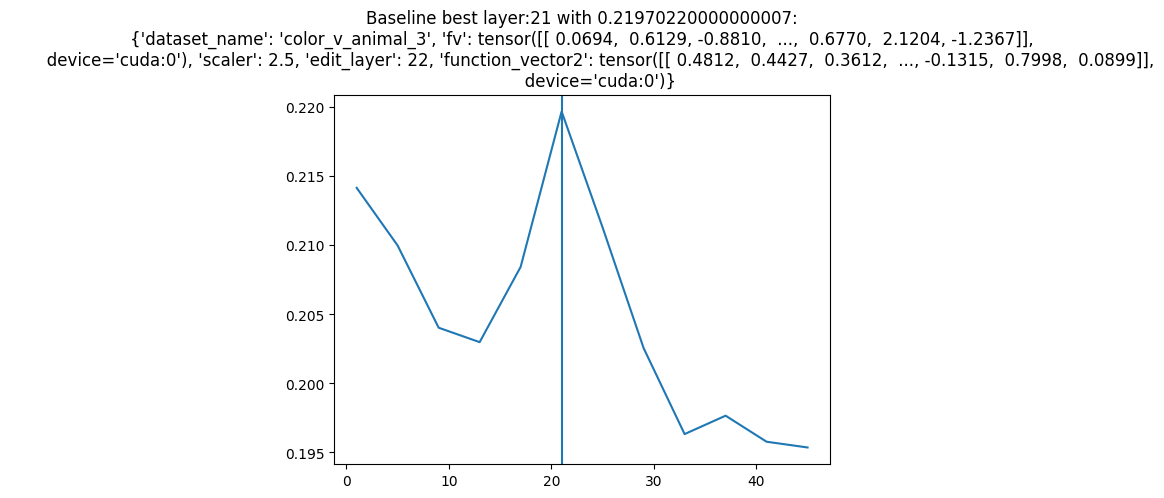

In [ ]:
# find best layer for distribution vector
scores2 = []
avg_scores2 = []
params = {
    "dataset_name": distr1,
    "fv":fv2,
    "scalar":2.5,
    "edit_layer":22,
    "function_vector2":fv1_notask
    }

for layer in layers:
  res, avg = run_expt(**params, edit_layer2=layer)
  scores2.append(res)
  avg_scores2.append(avg)

# get max score and plot
max_layer2, max_avg_score2 = max(zip(layers, avg_scores2), key=lambda x:x[1])
plt.plot(layers, avg_scores2)
plt.axvline(max_layer2)
plt.title(f"Baseline best layer:{max_layer2} with {max_avg_score2}:\n{params}")

FV_result_list:  [0.12169, 0.04988, 0.05661, 0.09721, 0.12006, 0.01769, 0.04208, 0.11088, 0.06841, 0.03593, 0.23572, 0.13128, 0.01262, 0.09455, 0.27743, 0.165, 0.22312, 0.11368, 0.0454, 0.15583, 0.00284, 0.0551, 0.15596, 0.05674, 0.20243, 0.15545, 0.03625, 0.03448, 0.09033, 0.00917, 0.16493, 0.09308, 0.12135, 0.20186, 0.00937, 0.00764, 0.07693, 0.03675, 0.05619, 0.0635, 0.0602, 0.09481, 0.13886, 0.07911, 0.07594, 0.05245, 0.13676, 0.02669, 0.23717, 0.07904, 0.00943, 0.0472, 0.02254, 0.11466, 0.20243, 0.10388, 0.07879, 0.12071, 0, 0, 0.044, 0.0598, 0.00448, 0.15297, 0.16394, 0.27092, 0.13017, 0.06582, 0.08774, 0.26357, 0, 0.22162, 0.08108, 0.0998, 0.07401, 0.36705, 0.06749, 0.03435, 0.00786, 0.10158, 0.0321, 0.20889, 0.1055, 0.07055, 0.2926, 0.35506, 0.03076, 0.0476, 0.34601, 0.13281, 0.04677, 0.29018, 0.16682, 0.14141, 0.09832, 0.05707, 0.12685, 0.02174, 0.03741, 0.12895, 0.10064]
avg FV_result:  0.10517207920792074
FV_result_list:  [0.12649, 0.15868, 0.0344, 0.16717, 0.0963, 0.06792, 

Text(0.5, 1.0, "Baseline best layer:25 with 0.1745561:\n{'dataset_name': 'color_v_animal_3', 'fv': tensor([[ 0.0694,  0.6129, -0.8810,  ...,  0.6770,  2.1204, -1.2367]],\n       device='cuda:0'), 'scaler': 2.5}")

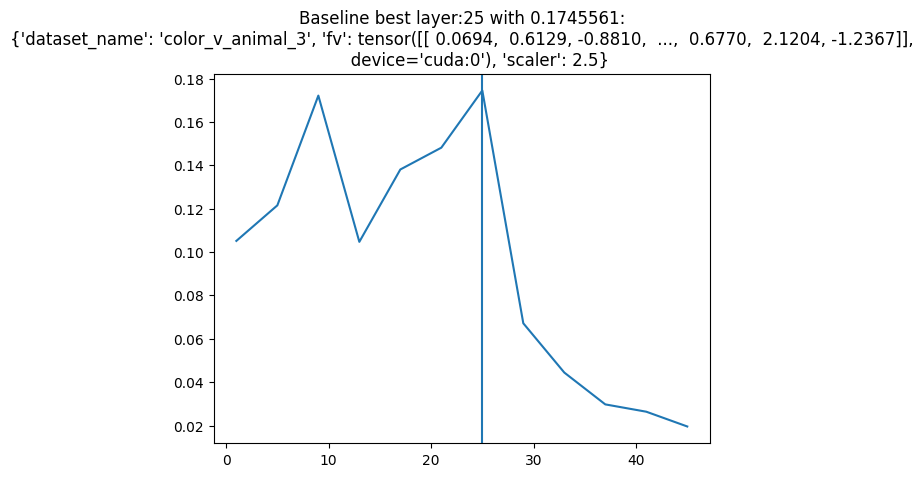

In [ ]:
# baseline
layers = [layer for layer in range(1,model_config['n_layers'],4)]
base_res_d1 = []
base_avg_res_d1 = []
params = {
    "dataset_name": distr1,
    "fv":fv2,
    "scalar":2.5,
    "edit_layer2":None,
    "function_vector2":None
    }

for layer in layers:
  res, avg = run_expt(**params, edit_layer=layer)
  base_res_d1.append(res)
  base_avg_res_d1.append(avg)

# get max score and plot
max_layer, max_avg_score = max(zip(layers, base_avg_res_d1), key=lambda x:x[1])
plt.plot(layers, base_avg_res_d1)
plt.axvline(max_layer)
plt.title(f"Baseline best layer:{max_layer} with {max_avg_score}:\n{params}")

In [ ]:
# mask = fv1.abs().ge(0.01)
# fv1_masked = fv1.detach().clone()
# fv1_masked[~mask] = 0

# fv1_masked2 = fv1.detach().clone()
# fv1_masked2[mask] = 0

# # number of nonzero elements
# (fv1_masked != 0).sum()

# Averaging FV Expts

In [ ]:
fv_dict = {'color_v_animal_FV': fv1, 'verb_v_adjective_FV': fv2, 'object_v_concept_FV': fv3, 'avg color_v_animal_FV & verb_v_adjective_FV': (fv1+fv2)/2, 'avg color_v_animal_FV & object_v_concept_FV': (fv1+fv3)/2, 'avg verb_v_adjective_FV & object_v_concept_FV': (fv2+fv3)/2}
def run_avg_fv_expt(query_dataset):
  for fv in fv_dict.keys():
    zero_shot_FV_result, avg_result, top_1_accuracy, top_5_accuracy, top_10_accuracy = run_expt(query_dataset, scalar = 1, fv=fv_dict[fv], print_statements=False)
    print('FV:', fv)
    print('Avg prob:',avg_result, 'Top1:', top_1_accuracy,'Top5:', top_5_accuracy,'Top10:', top_10_accuracy)

In [ ]:
# Query: color_v_animal_3
run_avg_fv_expt('color_v_animal_3')

In [ ]:
# Query: verb_v_adjective
run_avg_fv_expt('verb_v_adjective_3')

In [ ]:
# Query: object_v_concept_3
run_avg_fv_expt('object_v_concept_3')